In [1]:
import config_readwrite as crw
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import sys

import warnings
warnings.filterwarnings("ignore")
from statsmodels.formula.api import ols

import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

# read and write to config

In [2]:
DATE="20231115"

In [31]:
CONFIG = "/wynton/home/ahituv/fongsl/EMF/config.ini"

config, cfn = crw.read(CONFIG)

section = f"{DATE}_PEMF_HOb"
crw.check(config, section)

# read
DATA_PATH = config["local_path"]["data"]

# load
QPCR_PATH = os.path.join(DATA_PATH, "qpcr", section)
PLATE1="plate1.xlsx"
PLATE2="plate2.xlsx"


COMBINED = "qRT_PEMF.tsv"
LABELS = f"{DATE}_qPCR_labels.xlsx"

# write
config[section]["path"] = QPCR_PATH
config[section]["plate1"] = f"%(path)s/{PLATE1}"
config[section]["plate2"] = f"%(path)s/{PLATE2}"
config[section]["labels"] = f"%(path)s/{LABELS}"
config[section]["plate_combined"] = f"%(path)s/{COMBINED}"

crw.write(config, cfn)

RE = "/wynton/home/ahituv/fongsl/EMF/results/"
RE_DDCT = os.path.join(RE, f"{DATE}.ddCTs.tsv")

# go to datapath
os.chdir(QPCR_PATH)

In [4]:
%%bash
ls /wynton/home/ahituv/fongsl/EMF/data/qpcr/20231115_PEMF_HOb

20231115_qPCR_labels.xlsx
plate1.xlsx
plate2.xlsx
qRT_PEMF.xlsx


# labels

In [5]:
sample=pd.read_excel(LABELS, sheet_name="sample")
sample = sample.rename(columns={"Sample":'sample_id',
                               "Sample_group":"sample_name", 
                               "Replicate_w": "rep", 
                               "Plate":"plate"
                              })
sample

,sample_id,sample_name,rep,plate
0,S1,Control,1,1
1,S2,Control,2,1
2,S3,Control,3,1
3,S4,PEMF-physiostim 30',1,1
4,S5,PEMF-physiostim 30',2,1
5,S6,PEMF-physiostim 30',3,1
6,S7,PEMF-physiostim 60',1,1
7,S8,PEMF-physiostim 60',2,1
8,S9,PEMF-physiostim 60',3,1


## function

In [6]:
def plateToLongform(df, col_name):
    """transpose plate format into longform dataframe, name column"""
    transpose={}
    for n, row in df.iterrows():
        transpose[n] = row
    
    # make dataframe
    dfT = pd.DataFrame(pd.concat(transpose.values())).reset_index()

    # rename columns
    dfT.columns = ["col_pos", col_name]
    return dfT
    

In [7]:
def mergeDataFrames(df1, df2, col=None):
    """left merge two dataframes on index"""
    
    if col != None:
        merged = pd.merge(df1, df2, on=col)
    else:
        merged = pd.merge(df1, df2, left_index=True, right_index=True)
    return merged

## primers

In [8]:
# assumes no header names
SHEETS = ["platemap1-primers", "platemap2-primers"]
primer_dict={}
for sheet in SHEETS:
    primers=pd.read_excel(LABELS, sheet_name=sheet,
                          header=None, names=np.arange(1,13))

    col_name="primers"
    primersT= plateToLongform(primers, col_name)
    
    # edit names
    primersT.loc[primersT["primers"]=="Hsp70c", 'primers'] = "HSP70C"
    primersT.loc[primersT["primers"]=="HSP70c", 'primers'] = "HSP70C"

    # add to dictionary
    primer_dict[sheet] = primersT

# drop the old index
primersT = pd.concat(primer_dict.values()).reset_index(drop=True)

In [9]:
primersT.tail(12)

,col_pos,primers
180,1,ACTB
181,2,ACTB
182,3,ACTB
183,4,ACTB
184,5,ACTB
185,6,ACTB
186,7,ACTB
187,8,ACTB
188,9,ACTB
189,10,ACTB


## cdna

In [10]:
CDNAS = ["platemap1-cdna", "platemap2-cdna"]
cdna_dict={}
for sheet in CDNAS:

    cdna = pd.read_excel(LABELS, sheet_name=sheet, 
                         header=None, names=np.arange(1, 13))

    col_name = "sample_id"
    cdnaT = plateToLongform(cdna, col_name)
    
    # rename empty columns
    cdnaT.loc[cdnaT['sample_id']=="empty", 'sample_id'] = 'noRT'
    cdnaT.loc[cdnaT['sample_id'].isna(), 'sample_id'] = 'noRT'
    
    # add to dictionary
    cdna_dict[sheet] = cdnaT

cdnaT = pd.concat(cdna_dict.values()).reset_index(drop=True)

In [11]:
cdnaT.tail(12)

,col_pos,sample_id
180,1,S1
181,2,S2
182,3,S3
183,4,S4
184,5,S5
185,6,S6
186,7,S7
187,8,S8
188,9,S9
189,10,noRT


## results

In [12]:
ROWS = ["A", "B", "C", "D", "E", 'F', "G", "H"]

alphanum =[]
for letter in ROWS:
    for n in np.arange(1,13):
        if n <10:
            alphanum.append(f"{letter}0{n}")
        else:
            alphanum.append(f"{letter}{n}")
        
# make df from columns
plate_map = pd.DataFrame(alphanum)

# rename the columns
plate_map.columns=["Well Position"]
plate_map

,Well Position
0,A01
1,A02
2,A03
3,A04
4,A05
...,...
91,H08
92,H09
93,H10
94,H11


In [13]:
PLATES = [PLATE1, PLATE2]
plate_dict = {}
for plate in PLATES:
    plate1 = pd.read_excel(plate, 
                           #sheet_name="Results", 
                            usecols = ["Well Position", "CT"])

    # replace undetermined with None
    plate1.loc[plate1["CT"]=="Undetermined", "CT"] = None
    plate_ = pd.merge(plate_map, plate1, how="left")
    plate_["plate"] = plate
    plate_dict[plate]=plate_

plate1 = pd.concat(plate_dict.values()).reset_index(drop=True)

## merge

In [14]:
### primer information

df = mergeDataFrames(plate1, primersT)
df.tail(12)

,Well Position,CT,plate,col_pos,primers
180,H01,25.206369,plate2.xlsx,1,ACTB
181,H02,24.502281,plate2.xlsx,2,ACTB
182,H03,25.07696,plate2.xlsx,3,ACTB
183,H04,24.837872,plate2.xlsx,4,ACTB
184,H05,24.664423,plate2.xlsx,5,ACTB
185,H06,24.980604,plate2.xlsx,6,ACTB
186,H07,24.735514,plate2.xlsx,7,ACTB
187,H08,24.832857,plate2.xlsx,8,ACTB
188,H09,24.754274,plate2.xlsx,9,ACTB
189,H10,None,plate2.xlsx,10,ACTB


In [15]:
### sample information

df = mergeDataFrames(df, cdnaT)

### sample name

df = pd.merge(df, sample, how="left", on="sample_id")
df["sample_name"] = df["sample_name"].fillna("noRT")
df.tail(12)

,Well Position,CT,plate_x,col_pos_x,primers,col_pos_y,sample_id,sample_name,rep,plate_y
180,H01,25.206369,plate2.xlsx,1,ACTB,1,S1,Control,1.0,1.0
181,H02,24.502281,plate2.xlsx,2,ACTB,2,S2,Control,2.0,1.0
182,H03,25.07696,plate2.xlsx,3,ACTB,3,S3,Control,3.0,1.0
183,H04,24.837872,plate2.xlsx,4,ACTB,4,S4,PEMF-physiostim 30',1.0,1.0
184,H05,24.664423,plate2.xlsx,5,ACTB,5,S5,PEMF-physiostim 30',2.0,1.0
185,H06,24.980604,plate2.xlsx,6,ACTB,6,S6,PEMF-physiostim 30',3.0,1.0
186,H07,24.735514,plate2.xlsx,7,ACTB,7,S7,PEMF-physiostim 60',1.0,1.0
187,H08,24.832857,plate2.xlsx,8,ACTB,8,S8,PEMF-physiostim 60',2.0,1.0
188,H09,24.754274,plate2.xlsx,9,ACTB,9,S9,PEMF-physiostim 60',3.0,1.0
189,H10,None,plate2.xlsx,10,ACTB,10,noRT,noRT,NaN,NaN


# results 

## ct values

[Text(0, 0, 'Control'),
 Text(1, 0, "PEMF-physiostim 30'"),
 Text(2, 0, "PEMF-physiostim 60'"),
 Text(3, 0, 'noRT')]

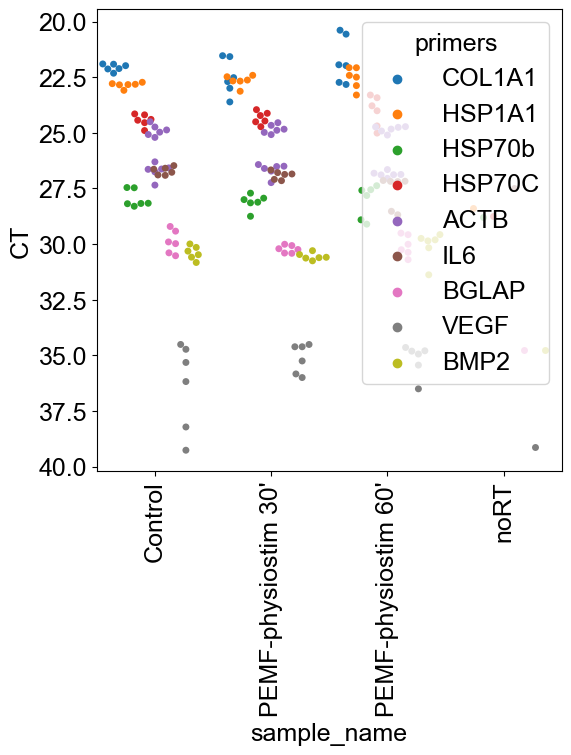

In [16]:
x="sample_name"
y="CT"
data=df#.loc[df["col_pos_x"].astype(int)!= 12]
hue="primers"
fig, ax=plt.subplots(figsize = (6,6))
sns.swarmplot(x=x, y=y, data=data, hue=hue, dodge=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

## ANOVA

### columns

In [17]:
test = df.loc[df["CT"].astype(str)!="None"].copy()

# change datatypes
test[["col_pos_x", "primers", "sample_id"]] = test[["col_pos_x", "primers", "sample_id"]].astype(str) 

test["CT"] = test["CT"].astype(float)
test = sm.add_constant(test)

mod = ols("CT ~ C(col_pos_x) + C(plate_x)" , data=test)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     CT   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     9.452
Date:                Wed, 24 Jan 2024   Prob (F-statistic):           5.59e-14
Time:                        20:35:31   Log-Likelihood:                -478.30
No. Observations:                 187   AIC:                             982.6
Df Residuals:                     174   BIC:                             1025.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

### primers and samples

In [18]:
test = df.loc[df["CT"].astype(str)!="None"].copy()

# change datatypes
test[["col_pos_x", "primers", "sample_id"]] = test[["col_pos_x", "primers", "sample_id"]].astype(str) 

test["CT"] = test["CT"].astype(float)
test = sm.add_constant(test)

mod = ols("CT ~ C(primers) + C(sample_name)" , data=test)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     CT   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     384.6
Date:                Wed, 24 Jan 2024   Prob (F-statistic):          2.63e-116
Time:                        20:35:31   Log-Likelihood:                -223.62
No. Observations:                 187   AIC:                             471.2
Df Residuals:                     175   BIC:                             510.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [19]:
RE = "/wynton/home/ahituv/fongsl/EMF/results/"

## CT values

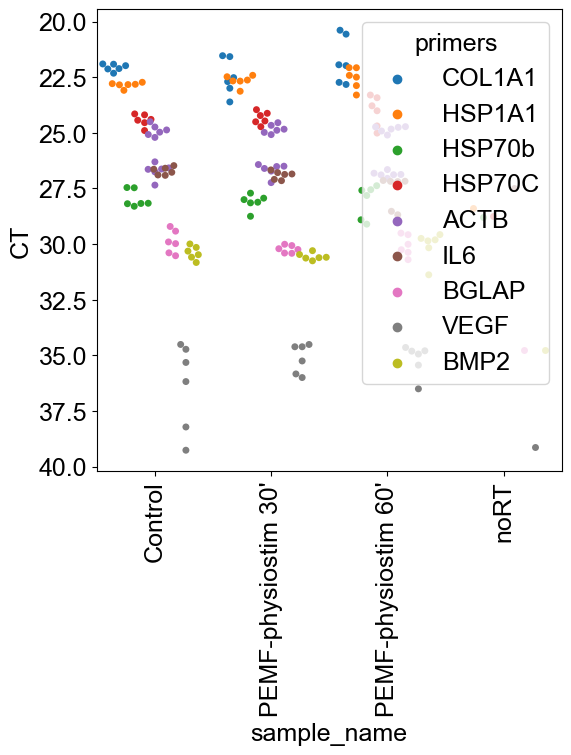

In [20]:
x="sample_name"
y="CT"
data=df#.loc[~df["col_pos_x"].isin([4, 12])]
hue="primers"

fig, ax=plt.subplots(figsize = (6,6))
sns.swarmplot(x=x, y=y, data=data, hue=hue, dodge=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig(os.path.join(RE, f"{DATE}_CT_vals"), bbox_inches="tight")

<Axes: xlabel='col_pos_x', ylabel='CT'>

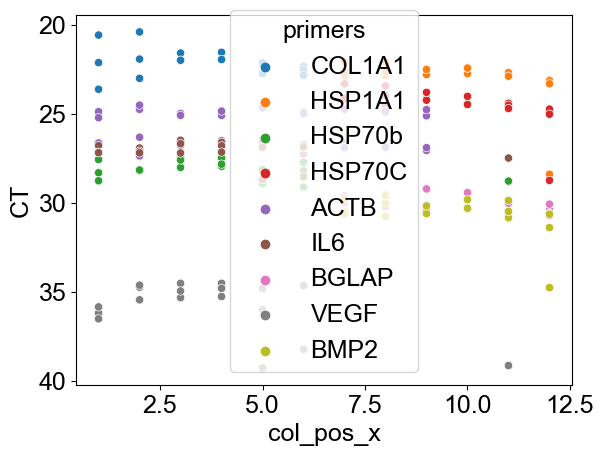

In [21]:
x="col_pos_x"
y="CT"
data=df
hue="primers"
sns.scatterplot(x=x, y=y, data=data, hue=hue)

<Axes: xlabel='col_pos_x', ylabel='CT'>

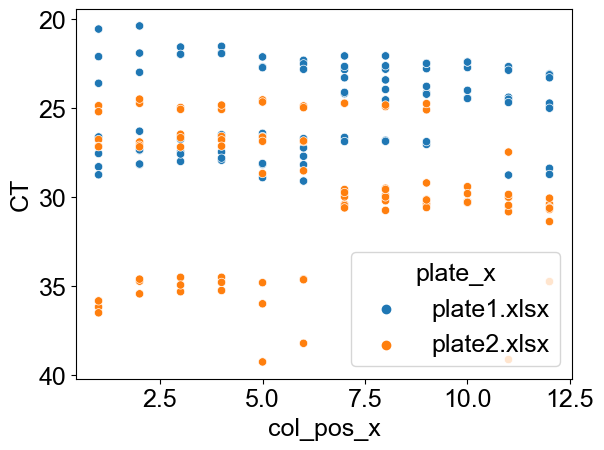

In [22]:
x="col_pos_x"
y="CT"
data=df
hue="plate_x"
sns.scatterplot(x=x, y=y, data=data, hue=hue)

In [23]:
def computeCT(df, control_gene):

    # mean ACTB CT per sample
    mean_ctrl = df[df['primers'] == control_gene].groupby('sample_name')['CT'].mean().reset_index()

    # rename columns
    mean_ctrl.rename(columns={'CT': 'Control_mean'}, inplace=True)

    # Merge mean ACTB values per sample
    test = pd.merge(df, mean_ctrl, on='sample_name', how='left')

    # dCT = obs CT - ACTB mean CT
    test['dCT'] = test['CT'] - test['Control_mean']

    # mean dCT per gene for control sample
    control_dCTs = test[test['sample_name'] == 'Control'].groupby(['primers'])['dCT'].mean().reset_index()  

    # rename columns
    control_dCTs.rename(columns={'dCT': 'Control_dCT_mean'}, inplace=True)

    # Merge control sample dCT values per gene
    test = pd.merge(test, control_dCTs, on='primers', how='left')
    test

    # ddCT = mean(dCT) sample - mean(dCT) control sample
    test['ddCT'] = test['dCT'] - test['Control_dCT_mean']

    # Assuming 'test' contains the 'ddCT' values for each gene

    # Calculate fold change using the formula 2^(-ddCT)
    test['fold_change'] = 2 ** (-test['ddCT'])
    
    return test

## compute ddCT with all datapoints

### ACTB

In [28]:
def plotDct(gene, df_, control_gene, date):
    if str(gene) != "empty" and str(gene) != "-":
        fig, ax = plt.subplots(figsize=(6, 6))
        data_ = df_.loc[(df_['sample_name'] != "noRT") &
                        (df_["primers"] == gene)
                        ].copy()

        plot = data_.groupby(["sample_name", "primers",  "rep", ])[
            "fold_change"].mean().reset_index()

        # stats
        statPS, pPS = stats.ttest_ind(data_.loc[data_["sample_name"] == "Control", "dCT"].to_list(),
                              data_.loc[data_["sample_name"] == "PEMF-physiostim 60'", "dCT"].to_list())


        x="sample_name"
        y='fold_change'
        hue="rep"
        data=plot
        order=[
            # 'Control',
            "PEMF-physiostim 60'",
            "PEMF-physiostim 30'",

        ]
        sns.boxplot(data=data,
                    x=x, y=y,
                    order=order,
                    color="grey",

                    )

        sns.swarmplot(data=data, x=x, y=y,
                      hue=hue,
                      palette="Set2",
                      order=order,
                      alpha=0.8, size=10)

        ax.set(xlabel=f'60min PS p={"{:.2E}".format(pPS)}',#, HF l3 p={"{:.1E}".format(pHF)}',
               ylabel='Fold Change (2**-ddCT)',
               title=gene,
               ylim=(0.2, 4)

               )
        ax.axhline(1, ls="--", color="grey", alpha=0.2)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                           horizontalalignment="right")

        plt.legend(title='replicate', bbox_to_anchor=(1, 1), frameon=False)

        plt.savefig(os.path.join(
            RE, f"{date}_hs.{control_gene}.{gene}.pdf"), bbox_inches="tight")

        # Show the plot
        plt.show()

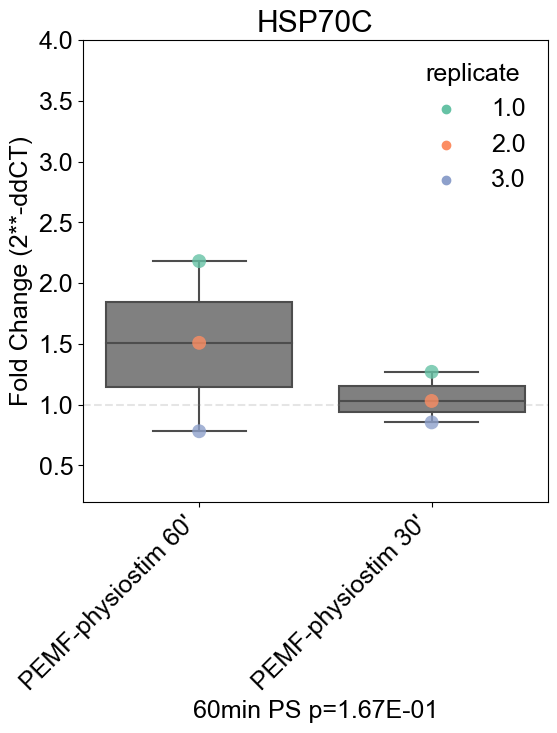

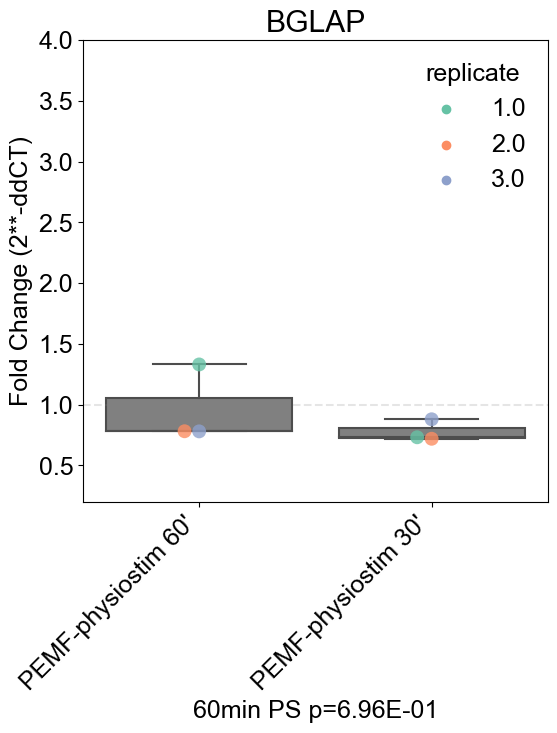

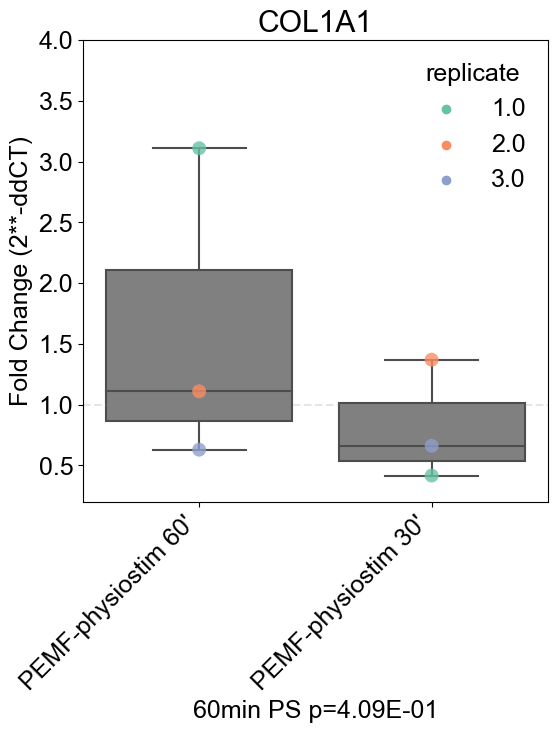

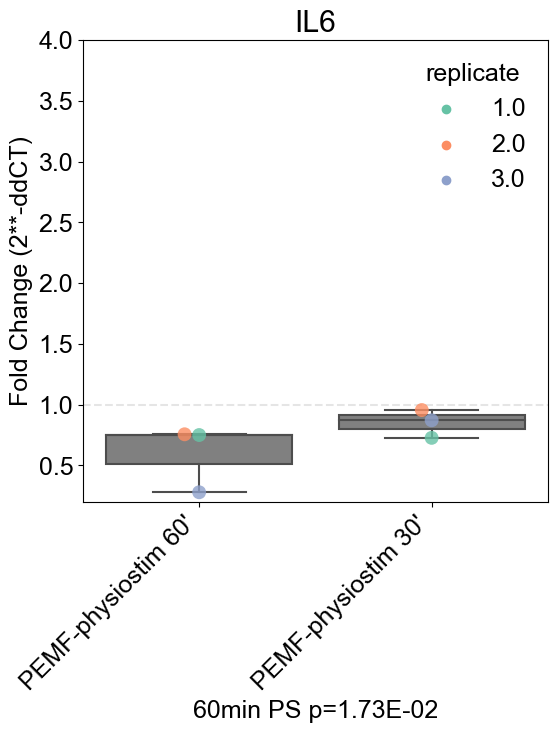

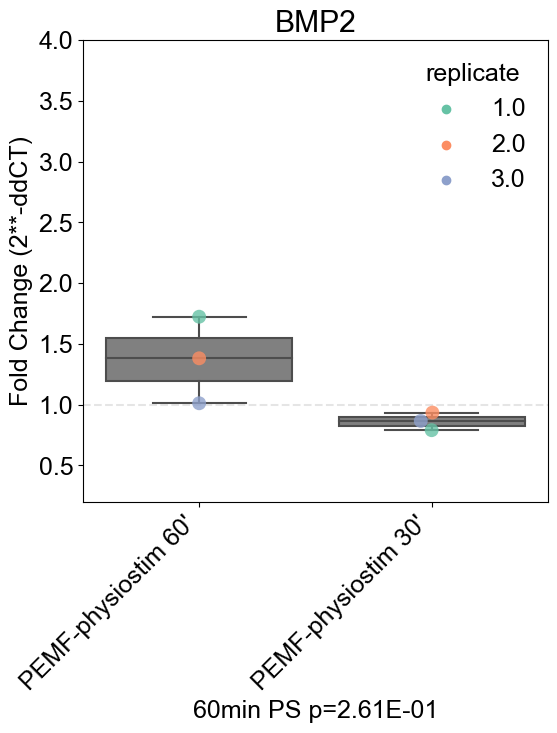

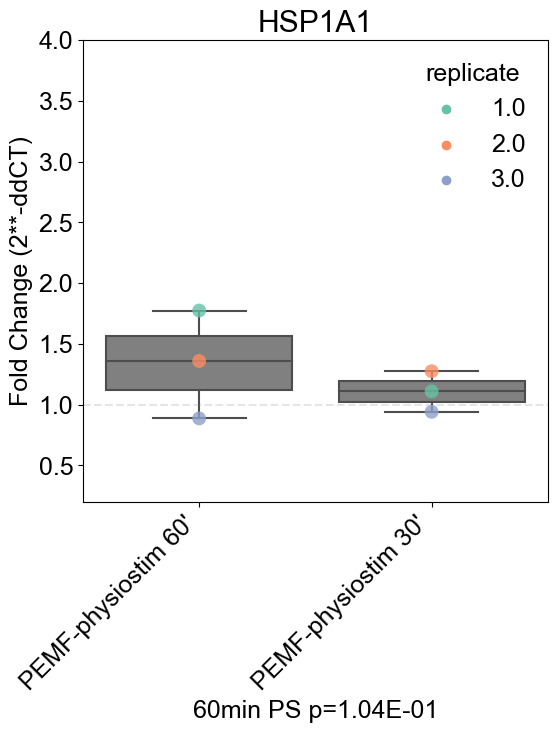

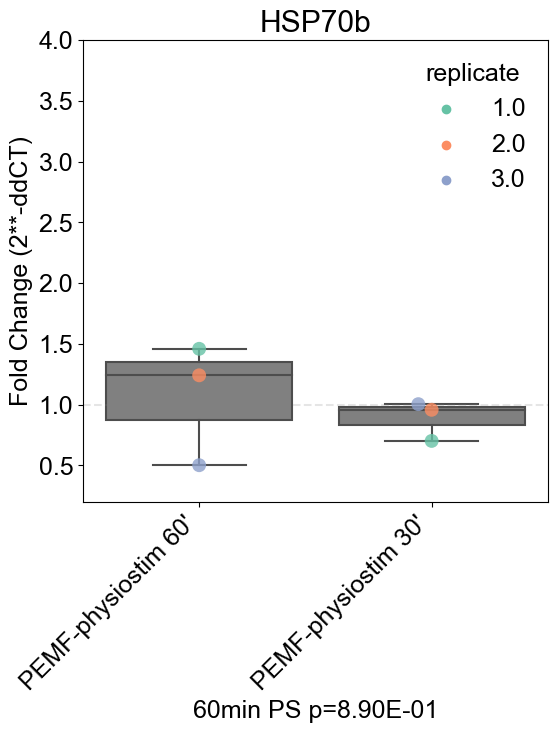

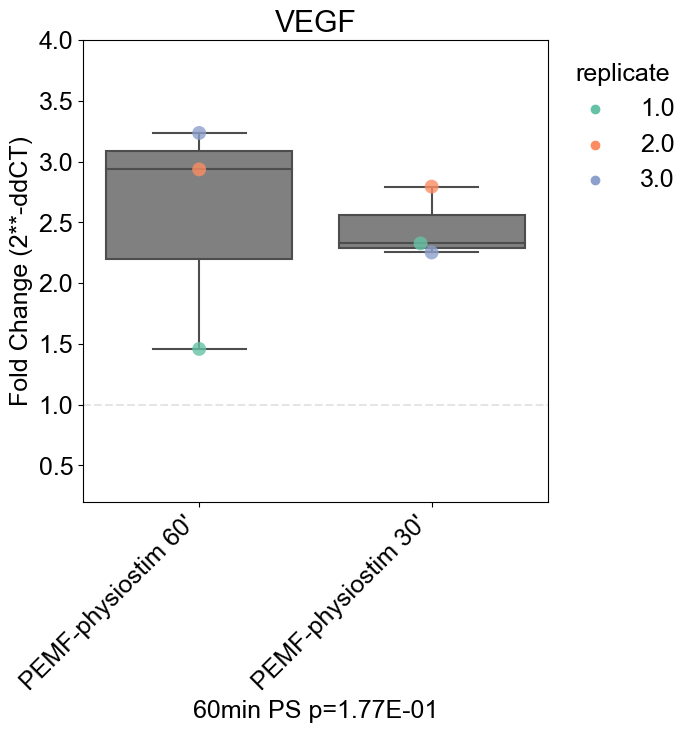

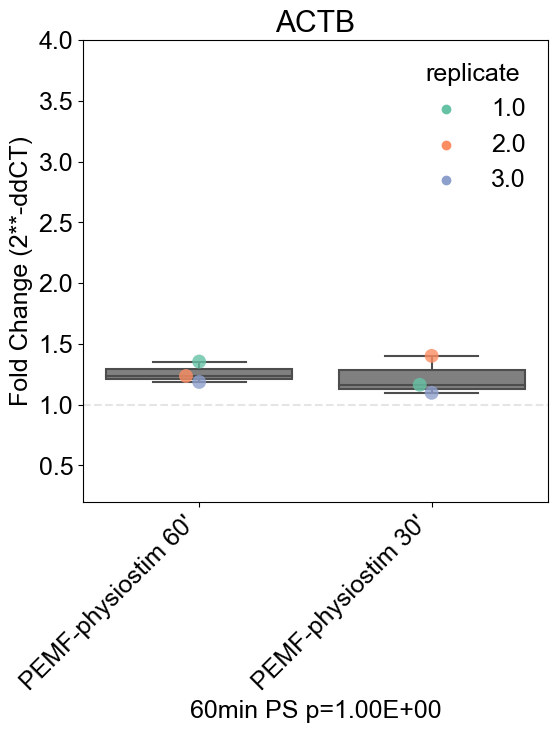

In [29]:
control_gene = 'ACTB'
df_ = computeCT(df, control_gene)
df_["control_gene"]=control_gene

# Assuming 'df_' contains the 'fold_change' values, and you want to create a boxplot with points

# Set up the boxplot and swarmplot using Seaborn

for gene in set(df_['primers']):

    plotDct(gene, df_, control_gene, DATE)

## write ddCT

In [32]:
write_cols = ['Well Position',
              'CT',
              'plate',
              'primers',
              'sample_name',
              'rep',
              'Experiment',
              'Control_mean',
              'dCT',
              'Control_dCT_mean',
              'ddCT',
              'fold_change', 
             "control_gene", 
             "date"]


df_.rename(columns={"plate_x":"plate"}, inplace=True)
df_['Experiment'] = 1
df_["date"] = DATE
df_[write_cols].to_csv(RE_DDCT, sep='\t', index=False)